In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.impute import KNNImputer
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")

# PREPROCESSING

In [4]:
def find_missing_percent(data):
    """
    Returns dataframe containing the total missing values and percentage of total
    missing values of a column.
    """
    miss_df = pd.DataFrame({'ColumnName':[],'TotalMissingVals':[],'PercentMissing':[]})
    for col in data.columns:
        sum_miss_val = data[col].isnull().sum()
        percent_miss_val = round((sum_miss_val/data.shape[0])*100,2)
        miss_df = miss_df.append(dict(zip(miss_df.columns,[col,sum_miss_val,percent_miss_val])),ignore_index=True)
    return miss_df

miss_df = find_missing_percent(train_data)
'''Columns with missing values'''
print(f"Number of columns with missing values: {str(miss_df[miss_df['PercentMissing']>0.0].shape[0])}")
display(miss_df[miss_df['PercentMissing']>0.0])


Number of columns with missing values: 12


,ColumnName,TotalMissingVals,PercentMissing
1,HomePlanet,201.0,2.31
2,CryoSleep,217.0,2.50
3,Cabin,199.0,2.29
4,Destination,182.0,2.09
5,Age,179.0,2.06
6,VIP,203.0,2.34
7,RoomService,181.0,2.08
8,FoodCourt,183.0,2.11
9,ShoppingMall,208.0,2.39
10,Spa,183.0,2.11


In [5]:
def nullval(data):
    data["RoomService"] = data["RoomService"].fillna(0)
    data["FoodCourt"] = data["FoodCourt"].fillna(0)
    data["ShoppingMall"] = data["ShoppingMall"].fillna(0)
    data["Spa"] = data["Spa"].fillna(0)
    data["VRDeck"] = data["VRDeck"].fillna(0)
    
    data["VIP"] = data["VIP"].fillna("Unknown")
    data["CryoSleep"] = data["CryoSleep"].fillna("Unknown")
    
    data["Name"] = data["Name"].fillna("Unknown")
    data["HomePlanet"] = data["HomePlanet"].fillna("Unknown")
    data["Destination"] = data["Destination"].fillna("Unknown")
    
    data["Cabin"] = data["Cabin"].fillna('U//U')
    data["Age"] = data["Age"].fillna(np.NaN)
    #data["CryoSleep"] = data["CryoSleep"].fillna("Unknown")
    
    return data

In [6]:
train_data = nullval(train_data)

In [7]:
miss_df = find_missing_percent(train_data)
'''Columns with missing values'''
print(f"Number of columns with missing values: {str(miss_df[miss_df['PercentMissing']>0.0].shape[0])}")
display(miss_df[miss_df['PercentMissing']>0.0])

Number of columns with missing values: 1


,ColumnName,TotalMissingVals,PercentMissing
5,Age,179.0,2.06


In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8693 non-null   object 
 2   CryoSleep     8693 non-null   object 
 3   Cabin         8693 non-null   object 
 4   Destination   8693 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8693 non-null   object 
 7   RoomService   8693 non-null   float64
 8   FoodCourt     8693 non-null   float64
 9   ShoppingMall  8693 non-null   float64
 10  Spa           8693 non-null   float64
 11  VRDeck        8693 non-null   float64
 12  Name          8693 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [9]:
name_encoder = LabelEncoder()
home_encoder = LabelEncoder()
dest_encoder = LabelEncoder()
cryo_encoder = LabelEncoder()
vip_encoder = LabelEncoder()
deck_encoder = LabelEncoder()
side_encoder = LabelEncoder()

def convert(data):
    # passenger id
    group,number = [],[]
    for dp in data["PassengerId"]:
        i,j = map(int,dp.split("_"))
        group.append(i)
        number.append(j)
    data["passenger_group"] = group
    data["passenger_number"] = number
    del data["PassengerId"]
        
    # passenger cabin
    deck,deck_num,deck_side = [],[],[]
    for dp in data.Cabin:
        try:
            i,j,k = dp.split('/')
            deck.append(i)
            deck_side.append(k)
            deck_num.append(int(j))
        except:
            deck_num.append(np.NaN)
    data["cabin_deck"] = deck
    data["cabin_num"] = deck_num
    data["cabin_side"] = deck_side
    del data["Cabin"]
    
    data["CryoSleep"] = data["CryoSleep"].replace({True: 'TRUE', False: 'FALSE'})
    data["VIP"] = data["VIP"].replace({True: 'TRUE', False: 'FALSE'})
    
    # encoders
    data.Name = name_encoder.fit_transform(data.Name)
    data.HomePlanet = home_encoder.fit_transform(data.HomePlanet)
    data.CryoSleep = cryo_encoder.fit_transform(data.CryoSleep)
    data.VIP = vip_encoder.fit_transform(data.VIP)
    data.Destination = dest_encoder.fit_transform(data.Destination)
    data.cabin_deck = deck_encoder.fit_transform(data.cabin_deck)
    data.cabin_side = side_encoder.fit_transform(data.cabin_side)
    
    data["amount"] = data["RoomService"]+data["FoodCourt"]+data["ShoppingMall"]+data["Spa"]+data["VRDeck"]
    del data["RoomService"],data["FoodCourt"],data["ShoppingMall"],data["Spa"],data["VRDeck"]
    
    return data

In [10]:
train_data = convert(train_data)

In [11]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   HomePlanet        8693 non-null   int32  
 1   CryoSleep         8693 non-null   int32  
 2   Destination       8693 non-null   int32  
 3   Age               8514 non-null   float64
 4   VIP               8693 non-null   int32  
 5   Name              8693 non-null   int32  
 6   Transported       8693 non-null   bool   
 7   passenger_group   8693 non-null   int64  
 8   passenger_number  8693 non-null   int64  
 9   cabin_deck        8693 non-null   int32  
 10  cabin_num         8494 non-null   float64
 11  cabin_side        8693 non-null   int32  
 12  amount            8693 non-null   float64
dtypes: bool(1), float64(3), int32(7), int64(2)
memory usage: 585.9 KB


In [12]:
miss_df = find_missing_percent(train_data)
'''Columns with missing values'''
print(f"Number of columns with missing values: {str(miss_df[miss_df['PercentMissing']>0.0].shape[0])}")
display(miss_df[miss_df['PercentMissing']>0.0])

Number of columns with missing values: 2


,ColumnName,TotalMissingVals,PercentMissing
3,Age,179.0,2.06
10,cabin_num,199.0,2.29


In [13]:
X = train_data.drop(["Transported"],axis=1)
y = train_data["Transported"]
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [14]:
def imputenull(data):
    column = data.columns
    age_imputer = KNNImputer(n_neighbors=1)
    data = age_imputer.fit_transform(data)
    data = pd.DataFrame(data, columns=column)
    return data

In [15]:
x_train = imputenull(x_train)
x_test = imputenull(x_test)

In [16]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   HomePlanet        8693 non-null   int32  
 1   CryoSleep         8693 non-null   int32  
 2   Destination       8693 non-null   int32  
 3   Age               8514 non-null   float64
 4   VIP               8693 non-null   int32  
 5   Name              8693 non-null   int32  
 6   passenger_group   8693 non-null   int64  
 7   passenger_number  8693 non-null   int64  
 8   cabin_deck        8693 non-null   int32  
 9   cabin_num         8494 non-null   float64
 10  cabin_side        8693 non-null   int32  
 11  amount            8693 non-null   float64
dtypes: float64(3), int32(7), int64(2)
memory usage: 577.4 KB


In [17]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6954 entries, 0 to 6953
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   HomePlanet        6954 non-null   float64
 1   CryoSleep         6954 non-null   float64
 2   Destination       6954 non-null   float64
 3   Age               6954 non-null   float64
 4   VIP               6954 non-null   float64
 5   Name              6954 non-null   float64
 6   passenger_group   6954 non-null   float64
 7   passenger_number  6954 non-null   float64
 8   cabin_deck        6954 non-null   float64
 9   cabin_num         6954 non-null   float64
 10  cabin_side        6954 non-null   float64
 11  amount            6954 non-null   float64
dtypes: float64(12)
memory usage: 652.1 KB


# Feature Selection

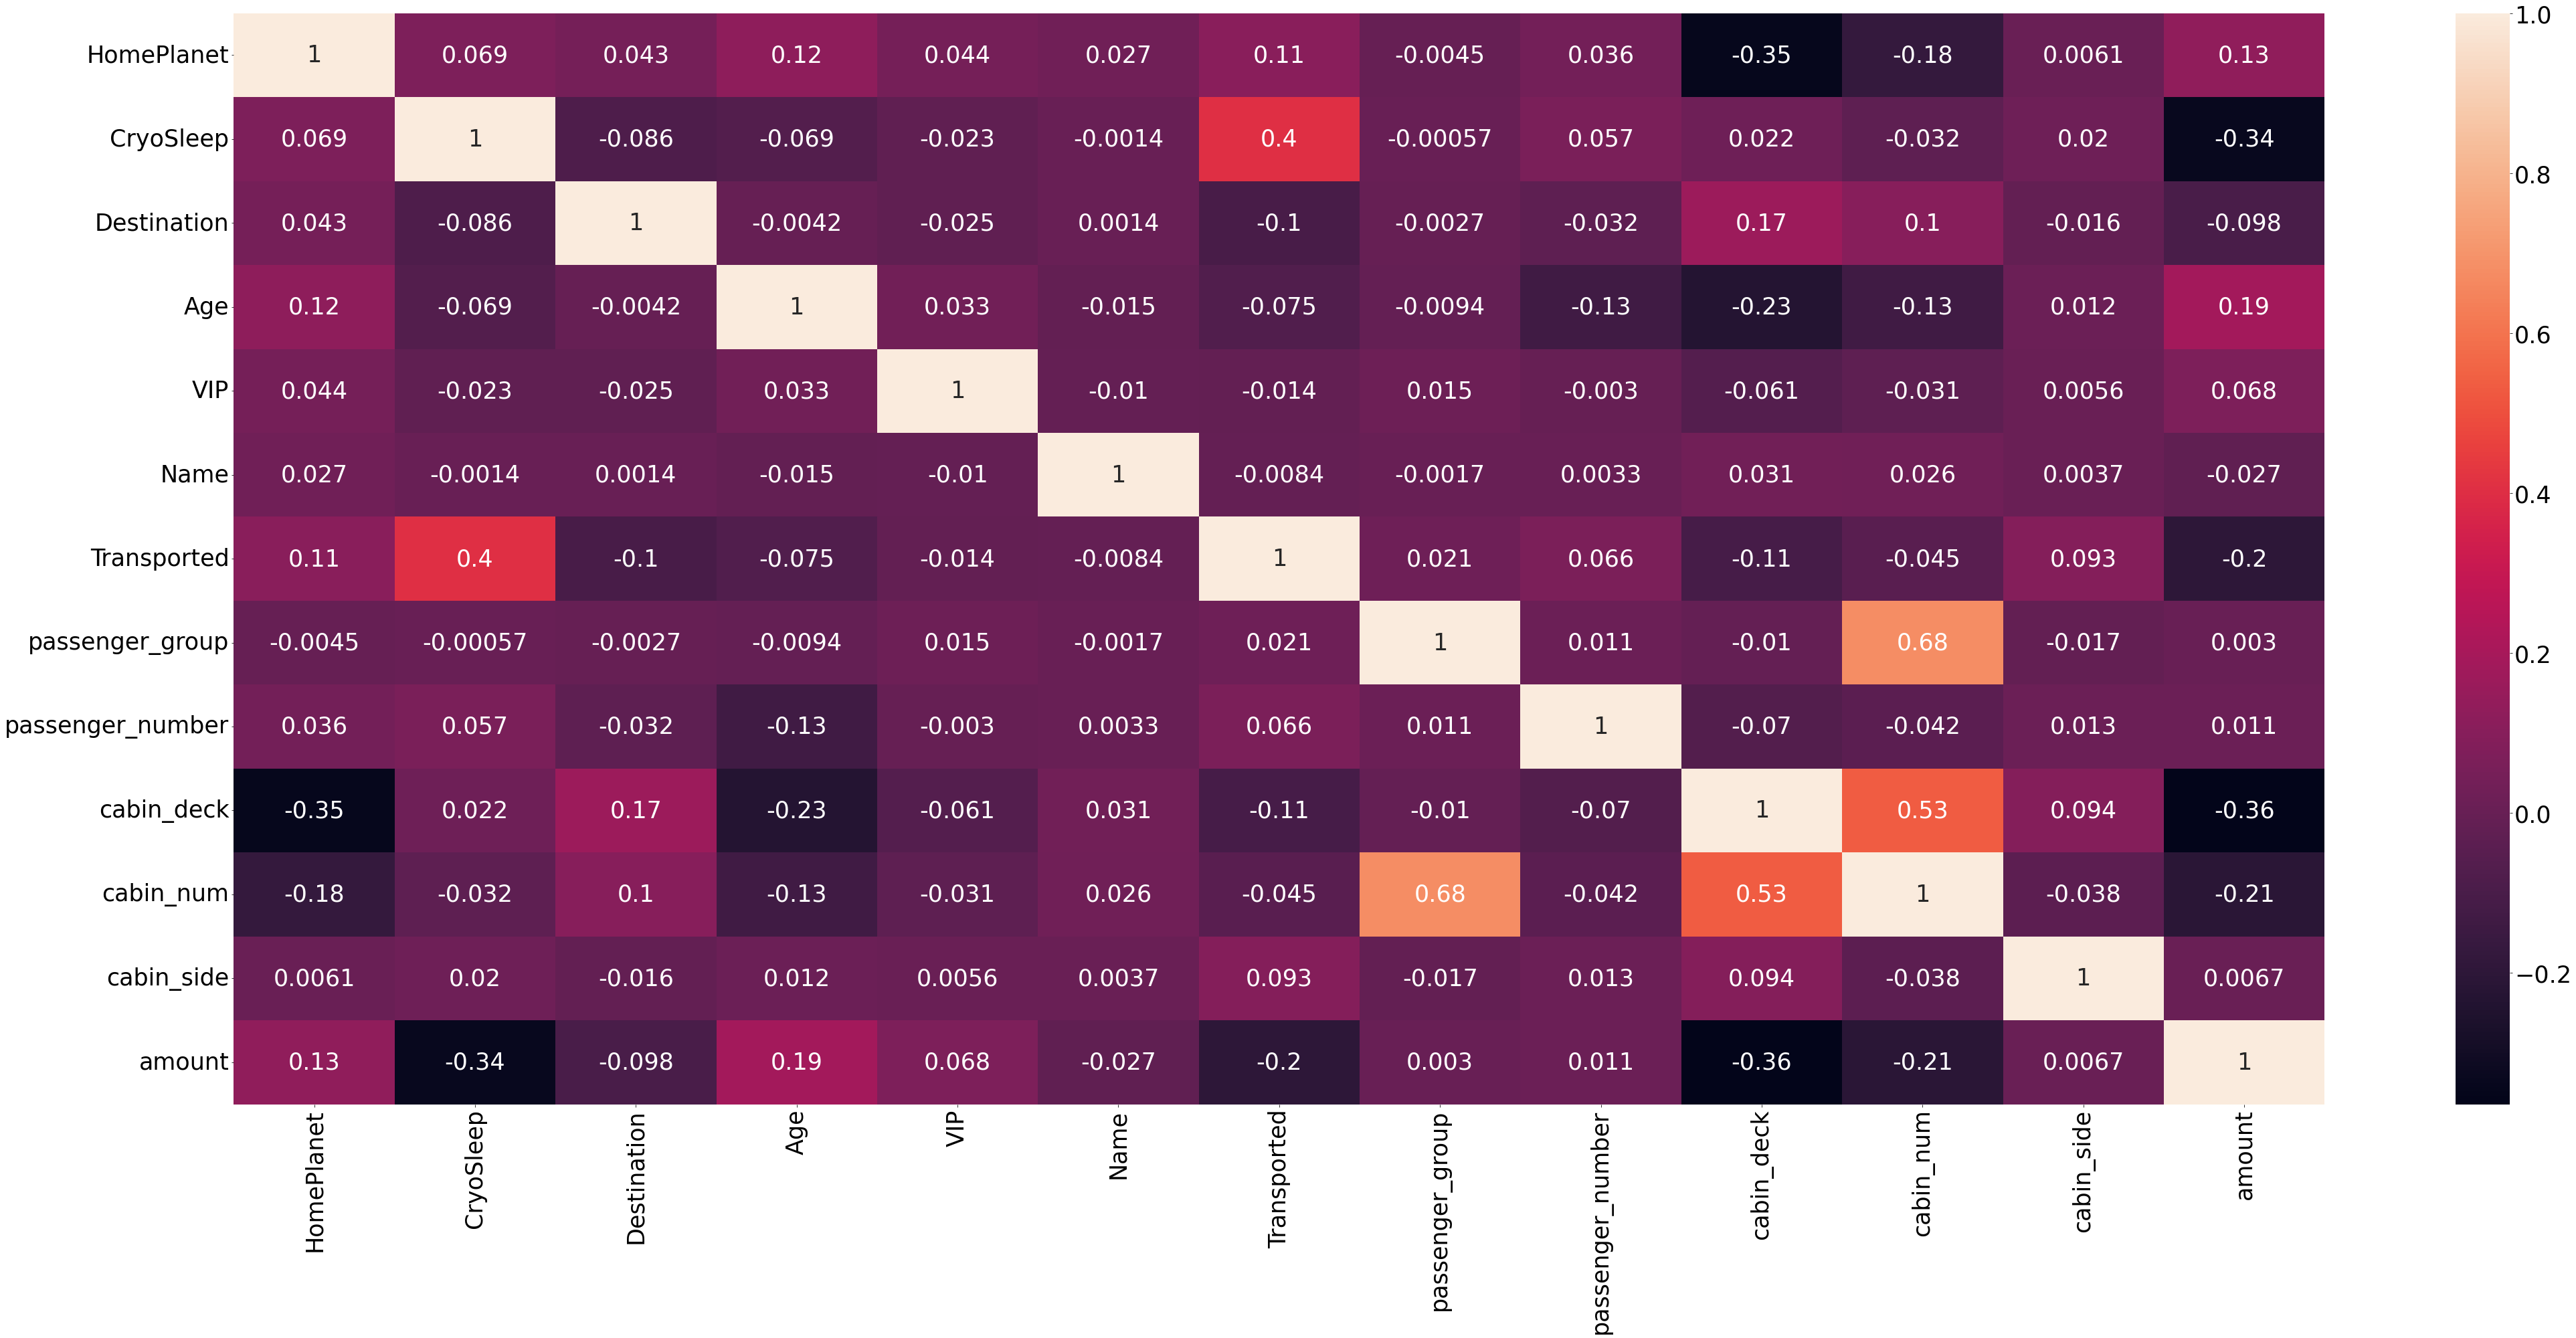

In [18]:
c = train_data.corr()
plt.figure(figsize = (70,30))
plt.rcParams.update({'font.size': 35})
sns.heatmap(c,annot=True,annot_kws={"size": 35})
plt.show()

In [19]:
features = list(c[c["Transported"]<0]["Transported"].index)

In [20]:
def FeatureSelected(x,y):
    bestfeatures = SelectKBest(score_func=chi2, k=10)
    fit = bestfeatures.fit(x,y)
    dfscores = pd.DataFrame(fit.scores_)
    pd.options.display.float_format = '{:.4f}'.format
    dfcolumns = pd.DataFrame(x.columns)
    featureScores = pd.concat([dfcolumns,dfscores],axis = 1)
    featureScores.columns = ["Specs","Score"]
    featureScores.sort_values("Score",ascending=False,inplace=True)
    return featureScores

In [21]:
print(FeatureSelected(x_train,y_train))

               Specs        Score
11            amount 1657080.2500
6    passenger_group    5257.0902
9          cabin_num    4590.9294
1          CryoSleep     855.0919
3                Age     249.4734
5               Name      83.2504
0         HomePlanet      79.5781
8         cabin_deck      60.6762
2        Destination      36.3196
10        cabin_side      30.6939
7   passenger_number      19.0880
4                VIP       1.2714


In [22]:
x_train = x_train[features]
x_test = x_test[features]

In [23]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6954 entries, 0 to 6953
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Destination  6954 non-null   float64
 1   Age          6954 non-null   float64
 2   VIP          6954 non-null   float64
 3   Name         6954 non-null   float64
 4   cabin_deck   6954 non-null   float64
 5   cabin_num    6954 non-null   float64
 6   amount       6954 non-null   float64
dtypes: float64(7)
memory usage: 380.4 KB


In [24]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1739 entries, 0 to 1738
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Destination  1739 non-null   float64
 1   Age          1739 non-null   float64
 2   VIP          1739 non-null   float64
 3   Name         1739 non-null   float64
 4   cabin_deck   1739 non-null   float64
 5   cabin_num    1739 non-null   float64
 6   amount       1739 non-null   float64
dtypes: float64(7)
memory usage: 95.2 KB


# Machine Learning Implimentation

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import BernoulliNB 
from sklearn import svm

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [26]:
def evaluation(y_test,y_pred):
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

In [27]:
accuracy_dict = {}
models = {}

In [28]:
from sklearn.naive_bayes import BernoulliNB 
naive = BernoulliNB()
naive.fit(x_train, y_train)
y_pred = naive.predict(x_test)

print(accuracy_score(y_test,y_pred))
accuracy_dict["Navier Bayes"] = accuracy_score(y_test,y_pred)
models["Navier Bayes"] = naive

0.7176538240368028


In [29]:
from sklearn.neighbors import KNeighborsClassifier
k=KNeighborsClassifier()
k.fit(x_train,y_train)
result=k.predict(x_test)

print(accuracy_score(y_test,result))
accuracy_dict["KNN"] = accuracy_score(y_test,result)
models["KNN"] = k

0.672225416906268


In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(x_train)
X_test = sc.transform(x_test)
Y_train = y_train
Y_test = y_test
lr=LogisticRegression()
lr.fit(X_train,Y_train)
Y_pred=lr.predict(X_test)

print(accuracy_score(Y_test,Y_pred))
accuracy_dict["Logistic"] = accuracy_score(Y_test,Y_pred)
models["Logistic"] = lr

0.6451983898792409


In [31]:
from sklearn.tree import DecisionTreeClassifier
d=DecisionTreeClassifier()
d.fit(x_train,y_train)
y_pred=d.predict(x_test)

print(accuracy_score(y_test,y_pred))
accuracy_dict["Decision Tree"] = accuracy_score(y_test,y_pred)
models["Decision Tree"] = d

0.6515238642898218


In [32]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier()
rf.fit(x_train,y_train)
y_pred=rf.predict(x_test)

print(accuracy_score(y_test,y_pred))
accuracy_dict["Random Forest"] = accuracy_score(y_test,y_pred)
models["Random Forest"] = rf

0.7165037377803335


In [33]:
from sklearn.ensemble import GradientBoostingClassifier
gbc=GradientBoostingClassifier()
gbc.fit(x_train,y_train)
y_pred=gbc.predict(x_test)

print(accuracy_score(y_test,y_pred))
accuracy_dict["Gradient Boost"] = accuracy_score(y_test,y_pred)
models["Gradient Boost"] = gbc

0.723404255319149


In [34]:
from sklearn.svm import SVC
svc=SVC()
svc.fit(x_train,y_train)
y_pred=svc.predict(x_test)

print(accuracy_score(y_test,y_pred))
accuracy_dict["SVM"] = accuracy_score(y_test,y_pred)
models["SVM"] = svc

0.7153536515238643


In [35]:
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

sc = StandardScaler()
X_train = sc.fit_transform(x_train)
X_test = sc.transform(x_test)
Y_train = y_train
Y_test = y_test
ann = tf.keras.models.Sequential()
ann.add(tf.keras.layers.Dense(units=200,activation="relu"))
ann.add(tf.keras.layers.Dense(units=100,activation="relu"))
ann.add(tf.keras.layers.Dense(units=20,activation="relu"))
ann.add(tf.keras.layers.Dense(units=10,activation="relu"))
ann.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))
ann.compile(optimizer="adam",loss="binary_crossentropy",metrics=['accuracy'])
ann.fit(X_train,Y_train,batch_size=32,epochs=100,steps_per_epoch=250)
Y_pred = ann.predict(X_test)>0.5
ann.summary() 

print(accuracy_score(Y_test,Y_pred))
accuracy_dict["ANN"] = accuracy_score(Y_test,Y_pred)
models["ANN"] = ann

Epoch 1/100
250/250 [==============================] - 1s 1ms/step - loss: 0.5996 - accuracy: 0.6716
Epoch 2/100
250/250 [==============================] - 0s 1ms/step - loss: 0.5515 - accuracy: 0.7245
Epoch 3/100
250/250 [==============================] - 0s 861us/step - loss: 0.5421 - accuracy: 0.7329
Epoch 4/100
250/250 [==============================] - 0s 1ms/step - loss: 0.5484 - accuracy: 0.7265
Epoch 5/100
250/250 [==============================] - 0s 905us/step - loss: 0.5374 - accuracy: 0.7372
Epoch 6/100
250/250 [==============================] - 0s 861us/step - loss: 0.5298 - accuracy: 0.7423
Epoch 7/100
250/250 [==============================] - 0s 793us/step - loss: 0.5359 - accuracy: 0.7349
Epoch 8/100
250/250 [==============================] - 0s 1ms/step - loss: 0.5299 - accuracy: 0.7349
Epoch 9/100
250/250 [==============================] - 0s 781us/step - loss: 0.5269 - accuracy: 0.7390
Epoch 10/100
250/250 [==============================] - 0s 889us/step - loss: 0.5

250/250 [==============================] - 0s 809us/step - loss: 0.4114 - accuracy: 0.7924
Epoch 81/100
250/250 [==============================] - 0s 837us/step - loss: 0.4088 - accuracy: 0.7923
Epoch 82/100
250/250 [==============================] - 0s 913us/step - loss: 0.4091 - accuracy: 0.7990
Epoch 83/100
250/250 [==============================] - 0s 933us/step - loss: 0.4100 - accuracy: 0.7931
Epoch 84/100
250/250 [==============================] - 0s 885us/step - loss: 0.3999 - accuracy: 0.7974
Epoch 85/100
250/250 [==============================] - 0s 813us/step - loss: 0.4057 - accuracy: 0.7947
Epoch 86/100
250/250 [==============================] - 0s 901us/step - loss: 0.4059 - accuracy: 0.7978
Epoch 87/100
250/250 [==============================] - 0s 1ms/step - loss: 0.4029 - accuracy: 0.8020
Epoch 88/100
250/250 [==============================] - 1s 2ms/step - loss: 0.4159 - accuracy: 0.7921
Model: "sequential"
_____________________________________________________________

In [36]:
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

# for modeling
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(Dense(16, input_shape=(X.shape[1],), activation='relu')) # Add an input shape! (features,)
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary() 
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

# early stopping callback
# This callback will stop the training when there is no improvement in  
# the validation loss for 10 consecutive epochs.  
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)

# now we just update our model fit call
history = model.fit(X, y,
                    callbacks=[es],
                    epochs=100, # you can set this to a big number!
                    batch_size=32,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 16)                208       
                                                                 
 dense_6 (Dense)             (None, 32)                544       
                                                                 
 dense_7 (Dense)             (None, 64)                2112      
                                                                 
 dense_8 (Dense)             (None, 128)               8320      
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 11,313
Trainable params: 11,313
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
218/218 [=============================

In [45]:
accuracy_dict

{'Navier Bayes': 0.7176538240368028,
 'KNN': 0.672225416906268,
 'Logistic': 0.6451983898792409,
 'Decision Tree': 0.6515238642898218,
 'Random Forest': 0.7165037377803335,
 'Gradient Boost': 0.723404255319149,
 'SVM': 0.7153536515238643,
 'ANN': 0.682576193214491}

# Final Implimentation with best accuracy algorithm

In [38]:
def Preprocessing(data):
    data = nullval(data)
    data = convert(data)
    data = imputenull(data)
    return data[features]

In [39]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [40]:
test_data = Preprocessing(test_data)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Destination  4277 non-null   float64
 1   Age          4277 non-null   float64
 2   VIP          4277 non-null   float64
 3   Name         4277 non-null   float64
 4   cabin_deck   4277 non-null   float64
 5   cabin_num    4277 non-null   float64
 6   amount       4277 non-null   float64
dtypes: float64(7)
memory usage: 234.0 KB


In [41]:
l = max(accuracy_dict, key=accuracy_dict.get)
final_predict = models[l].predict(test_data)

In [42]:
submission = pd.read_csv("data/sample_submission.csv")
submission["Transported"] = final_predict

In [43]:
my_submission = pd.DataFrame({'PassengerId': submission.PassengerId, 'Transported': final_predict})
my_submission.to_csv('data/final submission.csv', index=False)